source:
1. data https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data
2. github https://github.com/sumitdeole/A-B-testing-in-digital-marketing/tree/main

## Introduction

The case is A/B testing in digital marketing. The objective is to see effectiveness of campaign strategy using ad, estimate potential revenue, and determine if the differences between the groups are statistically significant.

- Treatment group: user see the ad
- Control group: user see Public Service Announcement (PSA) or nothing

## EDA

### Import Library

In [53]:
import pandas as pd #for data wrangling
import seaborn as sns #for visualization (histogram, boxplot)
import matplotlib.pyplot as plt #for plotting
import numpy as np #for numerical operation
import statsmodels.stats.api as sms #for statistical tool
from scipy.stats import (
    ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, 
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
)
from statsmodels.stats.proportion import proportions_ztest #Test for differences in proportions between groups
import warnings #hide warning in output

# Ignore warnings for clearer output
warnings.filterwarnings("ignore")

use of library in scipy.stat:
- ttest_1samp → One-sample t-test (compare sample mean to a known value)
- shapiro → Shapiro-Wilk test (check if data is normally distributed)
- levene → Levene’s test (check if two groups have equal variances)
- ttest_ind → Independent two-sample t-test (compare means of A vs B when normality assumptions hold)
- mannwhitneyu → Mann-Whitney U test (non-parametric alternative to t-test for independent samples).
- pearsonr → Pearson correlation coefficient (linear relationship)
- spearmanr → Spearman rank correlation (monotonic relationship, non-parametric)
- kendalltau → Kendall’s tau correlation (another non-parametric correlation)
- f_oneway → One-way ANOVA (compare means of 3+ groups)
- kruskal → Kruskal-Wallis test (non-parametric ANOVA alternative)

### Load Data

In [54]:
df = pd.read_csv("marketing_AB.csv")
df

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23
588097,588097,1327975,ad,False,1,Tuesday,23
588098,588098,1038442,ad,False,3,Tuesday,23
588099,588099,1496395,ad,False,1,Tuesday,23


In [55]:
#check data type
df.dtypes

Unnamed: 0        int64
user id           int64
test group       object
converted          bool
total ads         int64
most ads day     object
most ads hour     int64
dtype: object

In [56]:
# count column
df.groupby('test group').agg({'user id': 'nunique'})

,user id
test group,
ad,564577
psa,23524


### Data Pre-processing

In [57]:
#check missing value
df.isnull().sum().sum()

0

no missing value

In [58]:
#check value in a column
df['test group'].unique()

array(['ad', 'psa'], dtype=object)

#### Convert boolean column to integer
for easier analysis

In [59]:
df['converted_int'] = df['converted'].astype(int)
df

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,converted_int
0,0,1069124,ad,False,130,Monday,20,0
1,1,1119715,ad,False,93,Tuesday,22,0
2,2,1144181,ad,False,21,Tuesday,18,0
3,3,1435133,ad,False,355,Tuesday,10,0
4,4,1015700,ad,False,276,Friday,14,0
...,...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23,0
588097,588097,1327975,ad,False,1,Tuesday,23,0
588098,588098,1038442,ad,False,3,Tuesday,23,0
588099,588099,1496395,ad,False,1,Tuesday,23,0


#### Check outlier
from measure column. visualization using boxplot

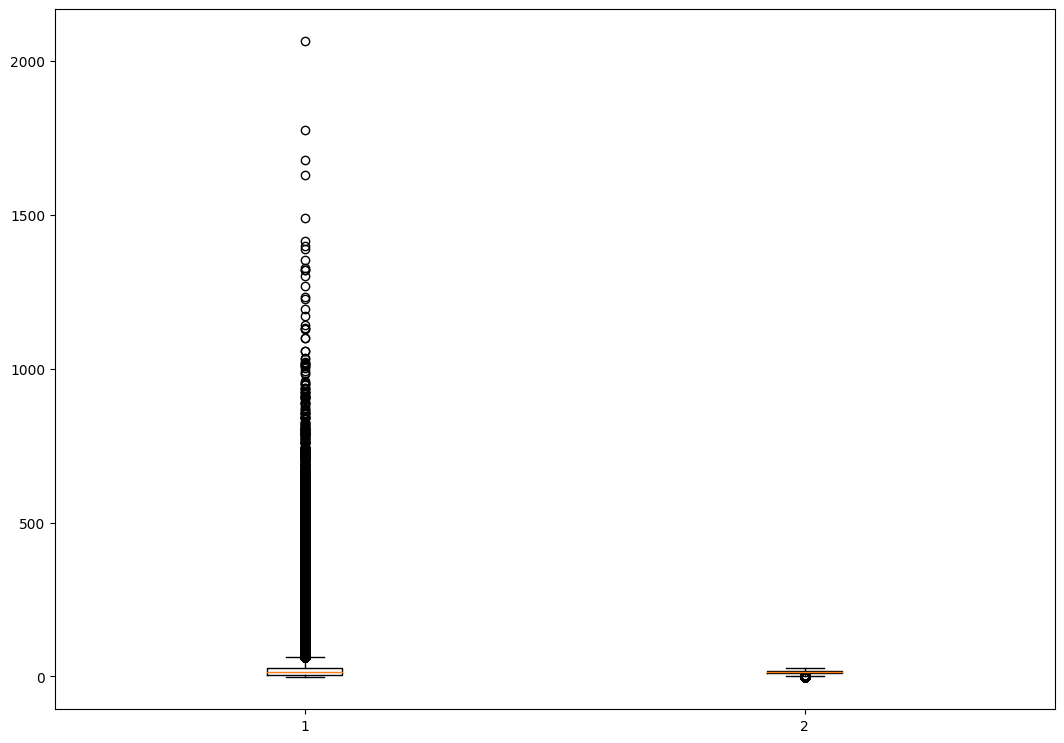

In [60]:
np.random.seed(10)

c_1 = np.random.normal(df['total ads'])
c_2 = np.random.normal(df['most ads hour'])
c = [c_1, c_2]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(c)

plt.show()

In [61]:
# see the IQR of column total ads

# Calculate IQR details
Q1 = df['total ads'].quantile(0.25)
Q3 = df['total ads'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

# Detect outliers
outliers = df[(df['total ads'] < lower_bound) | (df['total ads'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")


Q1: 4.0
Q3: 27.0
IQR: 23.0
Lower bound: -30.5
Upper bound: 61.5
Number of outliers: 52057


#### Remove outlier

In [62]:
df_clean = df[(df['total ads'] >= lower_bound) & (df['total ads'] <= upper_bound)]
df_clean

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour,converted_int
2,2,1144181,ad,False,21,Tuesday,18,0
7,7,1496843,ad,False,17,Sunday,18,0
8,8,1448851,ad,False,21,Tuesday,19,0
11,11,1637531,ad,False,47,Wednesday,13,0
12,12,1081965,ad,False,61,Tuesday,20,0
...,...,...,...,...,...,...,...,...
588096,588096,1278437,ad,False,1,Tuesday,23,0
588097,588097,1327975,ad,False,1,Tuesday,23,0
588098,588098,1038442,ad,False,3,Tuesday,23,0
588099,588099,1496395,ad,False,1,Tuesday,23,0


### Data Visualization

#### Total ads vs purchase status by test group

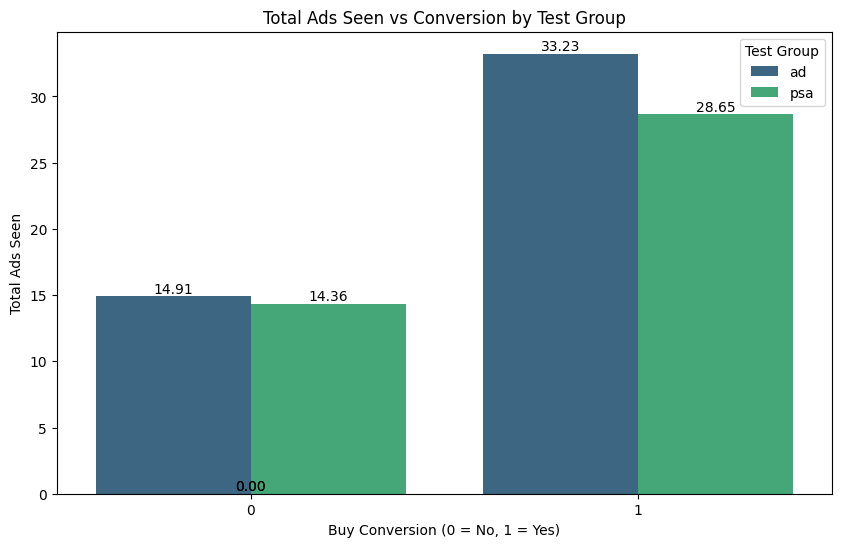

In [63]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_clean, x='converted_int', y='total ads', hue='test group', palette='viridis',
                 errorbar=None)

#add value label
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Total Ads Seen vs Conversion by Test Group')
plt.xlabel('Buy Conversion (0 = No, 1 = Yes)')
plt.ylabel('Total Ads Seen')
plt.legend(title='Test Group')

plt.show()

conversion = 1 means user bought the product.

So, user bought or not the product, ads catch more attention compared to PSA.

#### Total ads seen vs most ads day
to explore relationship between purchase status, total ads viewed, and the day most ads were seen, grouped by test group.

In [64]:
#grouped data
grouped_df = df_clean.groupby(["test group", "most ads day"]).agg({"total ads": "mean", "converted_int": "sum"}).reset_index()
grouped_df.head()

,test group,most ads day,total ads,converted_int
0,ad,Friday,15.255024,958
1,ad,Monday,14.825415,1324
2,ad,Saturday,15.944834,777
3,ad,Sunday,15.679764,987
4,ad,Thursday,14.510822,835


In [65]:
#rename column to be more understandable
grouped_df = grouped_df.rename(columns={'total ads':'average_ads_seen',
                                        'converted_int':'total_convert_buy'})
grouped_df

,test group,most ads day,average_ads_seen,total_convert_buy
0,ad,Friday,15.255024,958
1,ad,Monday,14.825415,1324
2,ad,Saturday,15.944834,777
3,ad,Sunday,15.679764,987
4,ad,Thursday,14.510822,835
5,ad,Tuesday,15.218691,1084
6,ad,Wednesday,14.668195,924
7,psa,Friday,14.178396,30
8,psa,Monday,13.234302,44
9,psa,Saturday,15.443123,21


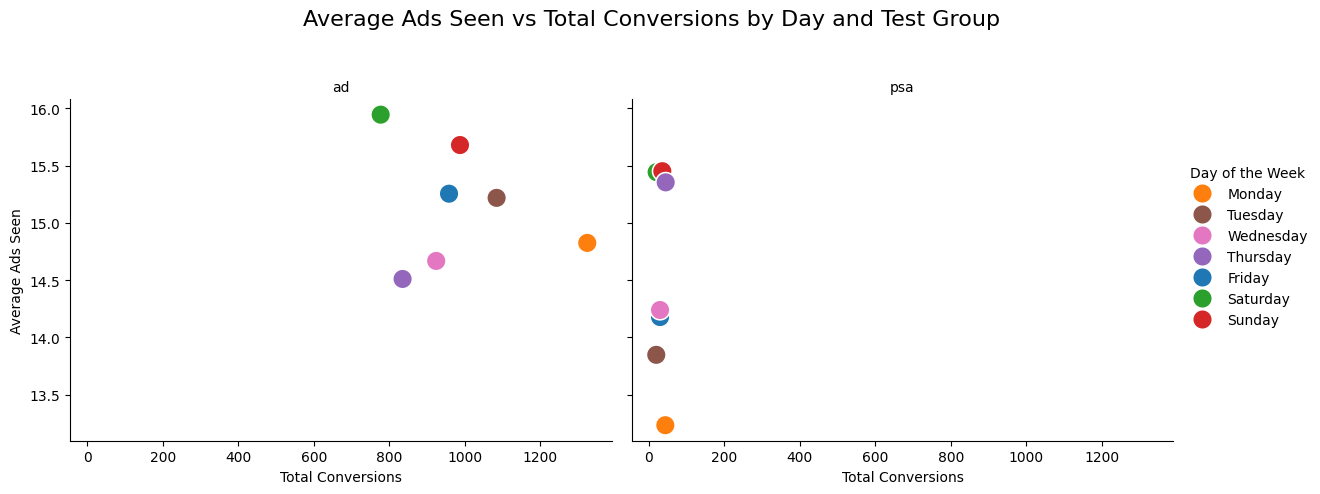

In [66]:
#create scatter plot
# Define order of days for legend
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Scatter Plot
g = sns.FacetGrid(grouped_df, col="test group", height=5, aspect=1.2)
g.map(sns.scatterplot, 'total_convert_buy', 'average_ads_seen', 'most ads day', palette='tab10', s=200)
g.add_legend(title='Day of the Week', label_order=days_order)
g.set_axis_labels('Total Conversions', 'Average Ads Seen')
g.set_titles('{col_name}')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Average Ads Seen vs Total Conversions by Day and Test Group', fontsize=16)
plt.show()

Plot above categorized by test group (ads and PSA). The plot shows correlation between number of ads seen by user and tendency to purchase the product. But in PSA group, high PSA seen not indicating much users convert to buy.

#### KDE plot
to see the distribution total ads seen by most ads day and test group

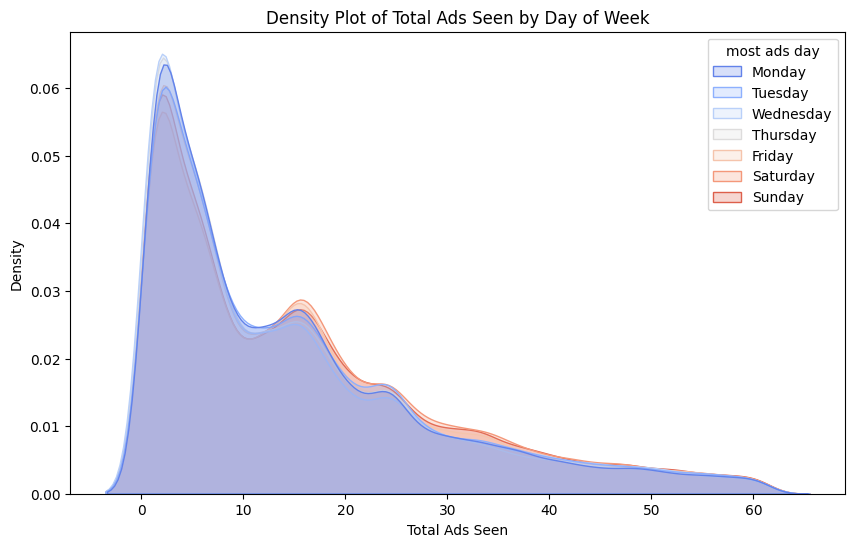

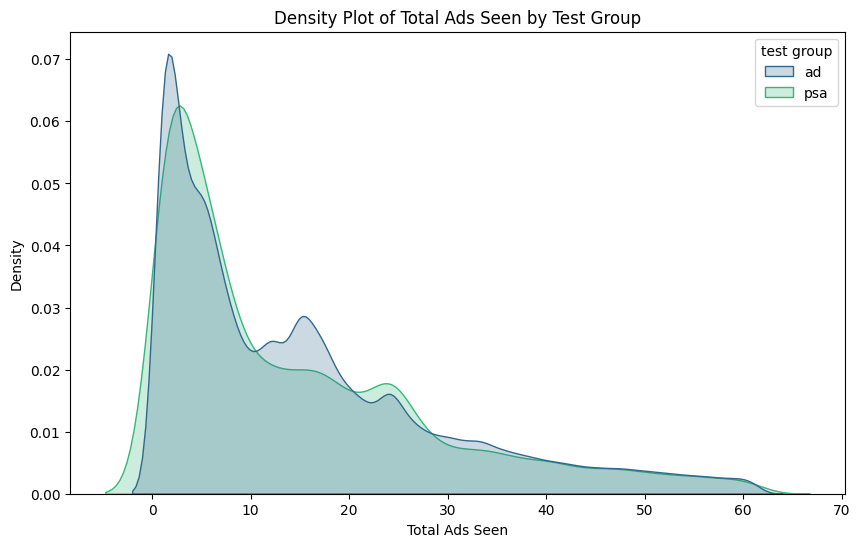

In [67]:
# KDE Plot by Most Ads Day
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean, x='total ads', hue='most ads day', hue_order=days_order,
            fill=True, common_norm=False, palette='coolwarm')
plt.title('Density Plot of Total Ads Seen by Day of Week')
plt.xlabel('Total Ads Seen')
plt.ylabel('Density')
plt.show()

# Plot by Test Group
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean, x='total ads', hue='test group', fill=True, common_norm=False, palette='viridis')
plt.title('Density Plot of Total Ads Seen by Test Group')
plt.xlabel('Total Ads Seen')
plt.ylabel('Density')
plt.show()

#### Total ads seen by most days and hours

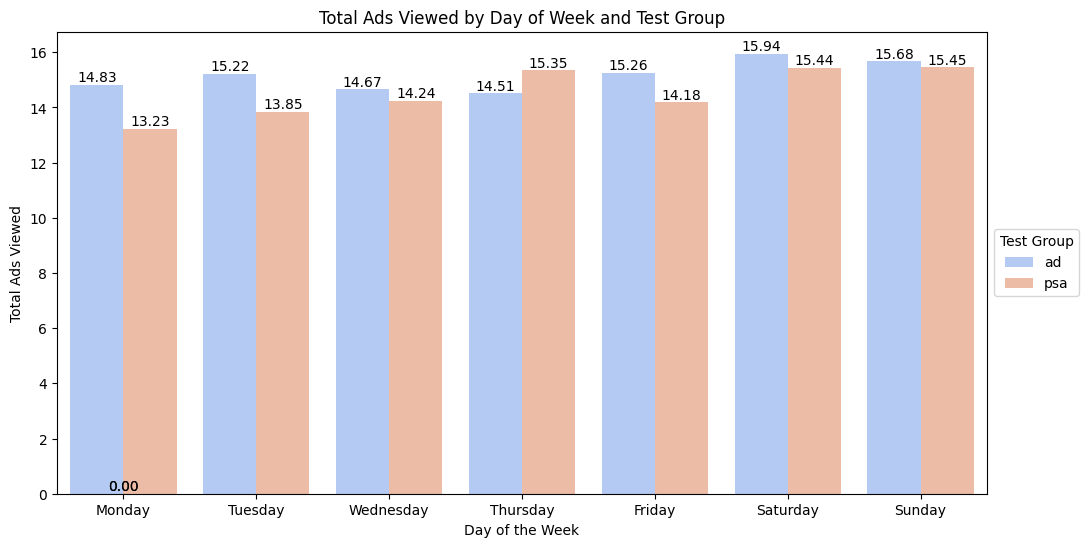

In [68]:
# Bar plot for total ads viewed by most ads day and test group with order
plt.figure(figsize=(12, 6))
ax_2 = sns.barplot(data=df_clean, x='most ads day', y='total ads', hue='test group', order=days_order, palette='coolwarm',
                   errorbar=None)

#add value label
for p in ax_2.patches:
    ax_2.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Total Ads Viewed by Day of Week and Test Group')
plt.xlabel('Day of the Week')
plt.ylabel('Total Ads Viewed')
plt.legend(title='Test Group', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

total ads seen various in different days.

### Hypothesis Testing

* **1: Check for Normality**
    * This is done using the **Shapiro-Wilk Test**, which assesses whether your data follows a bell-shaped curve.
    * The function looks at the p-value:
        * **If the p-value > 0.05**, the normality assumption is met, and the function moves to the next check.
        * **If the p-value is <= 0.05**, the normality assumption is violated. The function immediately skips the T-tests and proceeds to a non-parametric test.

* **2: Check for Homogeneity of Variances**
    * This step is only performed if both groups' data are found to be normal.
    * The **Levene's Test** is used to determine if the variances (or spread) of the two groups are approximately equal.
    * Again, the function looks at the p-value:
        * **If the p-value > 0.05**, the variances are considered homogeneous.
        * **If the p-value <= 0.05**, the variances are considered non-homogeneous.

* **3: Select and Perform the Final Comparison Test**
    * Based on the outcomes of the previous checks, the function selects the most suitable test to compare the two groups:
        * **Independent T-Test:** Used when both normality and homogeneity of variances are satisfied (both p-values > 0.05). This is the standard parametric test for comparing means.
        * **Welch's T-Test:** Used when normality is met but the assumption of equal variances is violated (Levene's p-value <= 0.05). This is a modified T-test that is more robust when variances are unequal.
        * **Mann-Whitney U Test:** This non-parametric test is the default fallback. It is used in two specific scenarios:
            1.  If the initial normality assumption fails (Shapiro-Wilk p-value <= 0.05).
            2.  If normality is met but variances are not homogeneous, the function also resorts to this non-parametric test. This offers an alternative to Welch's T-Test when the data might still have issues that compromise a parametric test.

In [69]:
def compare_groups(df, group_col, test_value, control_value, target_col):
    
    # H0: M1 = M2
    # H1: M1 != M2
    # REJECT H0 if p-value < 0.05.
    # DO NOT REJECT H0 if p-value > 0.05.
    
    # Normality Assumption
    print("-" * 150)
    print("Assumption Check Step 1")
    print("  - Normality Assumption (Shapiro-Wilk Test)")
    test_stat_test, pvalue_test = shapiro(df[df[group_col] == test_value][target_col])
    test_stat_control, pvalue_control = shapiro(df[df[group_col] == control_value][target_col])
    
    if pvalue_test > 0.05 and pvalue_control > 0.05:
        print("\n       * Normality assumption is met.")
        print(f'\n       * Test Group Stat = {test_stat_test:.4f}, p-value = {pvalue_test:.4f}')
        print(f'\n       * Control Group Stat = {test_stat_control:.4f}, p-value = {pvalue_control:.4f}')
        normality_assumption = True
    else:
        print("\n       * Normality assumption is not met.")
        print(f'\n       * Test Group Stat = {test_stat_test:.4f}, p-value = {pvalue_test:.4f}')
        print(f'\n       * Control Group Stat = {test_stat_control:.4f}, p-value = {pvalue_control:.4f}')
        normality_assumption = False
        
    # Homogeneity of Variances
    print("-" * 150)
    print("Assumption Check Step 2")
    print("  - Homogeneity of Variances (Levene's Test)")
    
    test_stat, pvalue = levene(df[df[group_col] == test_value][target_col], 
                               df[df[group_col] == control_value][target_col])
    
    if pvalue > 0.05:
        variance_assumption = True
        print("\n       * Variances are homogeneous.")
        print(f'\n       * Levene Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
    else:
        variance_assumption = False
        print("\n       * Variances are not homogeneous.")
        print(f'\n       * Levene Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
        
    # Parametric Test: T-Test
    if normality_assumption and variance_assumption:
        print("-" * 150)
        print("Assumptions met, performing Independent T-Test (Parametric)")
        
        test_stat, pvalue = ttest_ind(df[df[group_col] == test_value][target_col], 
                                      df[df[group_col] == control_value][target_col],
                                      equal_var=True)
        if pvalue > 0.05:
            print("Fail to Reject H0")
            print(f'T-Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
        else:
            print("Reject H0")
            print(f'T-Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
            
    elif normality_assumption and not variance_assumption:
        print("-" * 150)
        print("Normality met but variances are not homogeneous, performing Welch's T-Test")
        
        test_stat, pvalue = ttest_ind(df[df[group_col] == test_value][target_col], 
                                      df[df[group_col] == control_value][target_col],
                                      equal_var=False)
        if pvalue > 0.05:
            print("Fail to Reject H0")
            print(f'T-Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
        else:
            print("Reject H0")
            print(f'T-Test Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
    
    # Non-Parametric Test: Mann-Whitney U Test
    else:
        print("-" * 150)
        print("Assumptions not met, performing Mann-Whitney U Test (Non-Parametric)")
        
        test_stat, pvalue = mannwhitneyu(df[df[group_col] == test_value][target_col], 
                                         df[df[group_col] == control_value][target_col])
    
        if pvalue > 0.05:
            print("\n  * Fail to Reject H0")
            print(f'\n  * Mann-Whitney U Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')
        else:
            print("\n  * Reject H0")
            print(f'\n  * Mann-Whitney U Stat = {test_stat:.4f}, p-value = {pvalue:.4f}')

#### Hypothesis 1
H0: no significant difference in mean total ads between users who purchased (converted_int = 1) and who didn't (converted_int = 0)

H1: there is significant difference in mean total ads between user who purchased and didn't.

In [72]:
compare_groups(df_clean,'converted_int',1,0,'total ads')

------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 1
  - Normality Assumption (Shapiro-Wilk Test)

       * Normality assumption is not met.

       * Test Group Stat = 0.9600, p-value = 0.0000

       * Control Group Stat = 0.8634, p-value = 0.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 2
  - Homogeneity of Variances (Levene's Test)

       * Variances are not homogeneous.

       * Levene Stat = 1212.0188, p-value = 0.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
Assumptions not met, performing Mann-Whitney U Test (Non-Parametric)

  * Reject H0

  * Mann-Whitney U Stat = 2993998088.5000, p-value = 0.0000


**interpretation:**

reject H0. This means there is significant difference in mean total ads between users who purchased and didn't.


#### Hypothesis 2

H0: no significant difference in mean total ads between users who see/view ads on weekday vs weekend

H1: there is significant difference in mean total ads between users who see/view ads on weekday vs weekend

In [74]:
def add_weekday_weekend_column(df_clean, day_column, new_column_name):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekends = ['Saturday', 'Sunday']
    
    df_clean[new_column_name] = df_clean[day_column].apply(lambda x: 'weekdays' if x in weekdays else 'weekends' if x in weekends else 'Other')
    
    return df_clean


df_clean = add_weekday_weekend_column(df_clean, 'most ads day', 'weekdays_weekends')

compare_groups(df_clean,"weekdays_weekends", "weekdays", "weekends", "total ads")

------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 1
  - Normality Assumption (Shapiro-Wilk Test)

       * Normality assumption is not met.

       * Test Group Stat = 0.8592, p-value = 0.0000

       * Control Group Stat = 0.8783, p-value = 0.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 2
  - Homogeneity of Variances (Levene's Test)

       * Variances are not homogeneous.

       * Levene Stat = 199.2477, p-value = 0.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
Assumptions not met, performing Mann-Whitney U Test (Non-Parametric)

  * Reject H0

  * Mann-Whitney U Stat = 28083790182.0000, p-value = 0.0000


**interpretation:**

reject H0. There is significant difference in mean total ads between users who see ads on weekday and weekend.

#### Hypothesis 3

H0: no significant difference in mean total ads between ad group and PSA group

H1: there is significant difference in mean total ads between ad group and PSA group

In [75]:
compare_groups(df_clean,'test group','ad','psa','total ads')

------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 1
  - Normality Assumption (Shapiro-Wilk Test)

       * Normality assumption is not met.

       * Test Group Stat = 0.8651, p-value = 0.0000

       * Control Group Stat = 0.8476, p-value = 0.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
Assumption Check Step 2
  - Homogeneity of Variances (Levene's Test)

       * Variances are homogeneous.

       * Levene Stat = 0.1915, p-value = 0.6617
------------------------------------------------------------------------------------------------------------------------------------------------------
Assumptions not met, performing Mann-Whitney U Test (Non-Parametric)

  * Reject H0

  * Mann-Whitney U Stat = 5691411788.0000, p-value = 0.0000


**interpretation:**

reject H0. there is significant difference in mean total ads between ads group and PSA group.

### Conclusion

The analysis aimed to explore the effectiveness of ads compared to public service announcements (PSAs). The results from hypothesis testing confirmed a significant difference between the two groups, showing that using ads has a greater impact.